In [1]:
import numpy as np
import matplotlib.pyplot as plt
import harmonic as hm
from functools import partial
import emcee
import jax.numpy as jnp
import getdist.plots

In [2]:
def ln_posterior(x, inv_cov):
    """Compute log_e of posterior of n dimensional multivariate Gaussian.

    Args:

        x: Position at which to evaluate posterior.

    Returns:

        double: Value of posterior at x.

    """

    return -jnp.dot(x,jnp.dot(inv_cov,x))/2.0

In [3]:
# Define parameters for emcee sampling
ndim = 5                    # Dimensions
nchains = 200                # total number of chains to compute
samples_per_chain = 5000    # number of samples per chain
nburn = 2000                # number of samples to discard as burn in

# Construct a trivial inverse covariance (identity matrix)
inv_cov = np.zeros((ndim,ndim))
diag_cov = np.ones(ndim)
np.fill_diagonal(inv_cov, diag_cov)



In [4]:
# initialise random seed
np.random.seed(1)

# Set initial random position and state
pos = np.random.rand(ndim * nchains).reshape((nchains, ndim))
rstate = np.random.get_state()

# Instantiate and execute sampler
sampler = emcee.EnsembleSampler(nchains, ndim, ln_posterior, args=[inv_cov])
(pos, prob, state) = sampler.run_mcmc(pos, samples_per_chain, rstate0=rstate, progress=True)

# Collect samples into contiguous numpy arrays (discarding burn in)
samples = np.ascontiguousarray(sampler.chain[:,nburn:,:])
lnprob = np.ascontiguousarray(sampler.lnprobability[:,nburn:])

100%|██████████| 5000/5000 [00:20<00:00, 246.36it/s]


In [5]:
# Instantiate harmonic's chains class
chains = hm.Chains(ndim)
chains.add_chains_3d(samples, lnprob)

In [6]:
# Split the chains into the ones which will be used to train the machine
# learning model and for inference
chains_train, chains_infer = hm.utils.split_data(chains, training_proportion=0.5)

In [7]:
# Select RealNVP Model

n_scaled_layers = 2
n_unscaled_layers = 4
temperature = 0.8

model = hm.model.RealNVPModel(ndim, standardize=True, temperature=temperature)
epochs_num = 20
# Train model
model.fit(chains_train.samples, epochs=epochs_num, verbose= True)

Training NF: 100%|██████████| 20/20 [00:36<00:00,  1.83s/it]


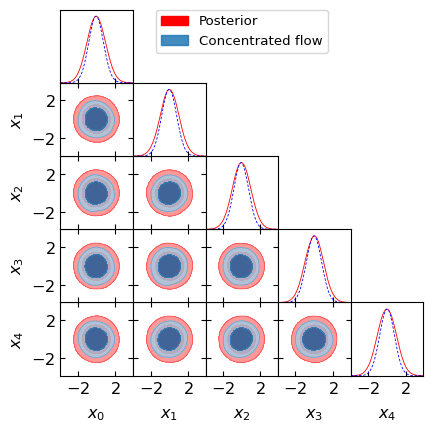

In [8]:
samples = samples.reshape((-1, ndim))
samp_num = samples.shape[0]
flow_samples = model.sample(samp_num)
hm.utils.plot_getdist_compare(samples, flow_samples)

In [9]:
# Instantiate harmonic's evidence class
ev = hm.Evidence(chains_infer.nchains, model)

# Pass the evidence class the inference chains and compute the evidence!
ev.add_chains(chains_infer)
ln_inv_evidence = ev.ln_evidence_inv
err_ln_inv_evidence = ev.compute_ln_inv_evidence_errors()

In [10]:
def ln_analytic_evidence(ndim, cov):
    """Compute analytic evidence for nD Gaussian.

    Args:

        ndim: Dimension of Gaussian.

        cov: Covariance matrix.

    Returns:

        double: Analytic evidence.

    """

    ln_norm_lik = 0.5*ndim*np.log(2*np.pi) + 0.5*np.log(np.linalg.det(cov))
    return ln_norm_lik

ln_inv_evidence_analytic = -ln_analytic_evidence(ndim, inv_cov)



In [11]:
print('ln inverse evidence (harmonic) = {} +/- {}'.format(ln_inv_evidence, err_ln_inv_evidence))
print('ln inverse evidence (analytic) = {}'.format(ln_inv_evidence_analytic))
print('nsigma = {}'.format(np.abs(ln_inv_evidence - ln_inv_evidence_analytic) / err_ln_inv_evidence))

ln inverse evidence (harmonic) = -4.597394943237305 +/- (-0.003238681537553719, 0.0032282263314258207)
ln inverse evidence (analytic) = -4.594692666023363
nsigma = [-0.83437571  0.83707799]
